In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
# Defining the hyperparameters -
num_epochs = 30
learning_rate = 0.01
batch_size = 64

# Preparing the dataset -

# Training Set -
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Test Set -
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Downloading the dataset

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_train)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True, num_workers=2)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:04<00:00, 34281237.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


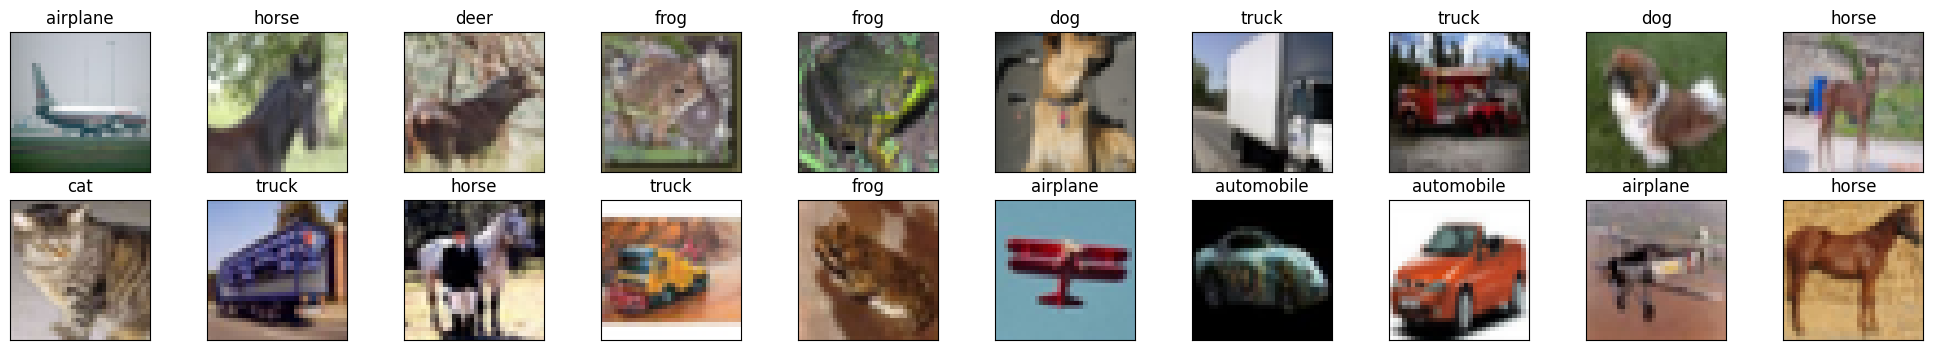

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

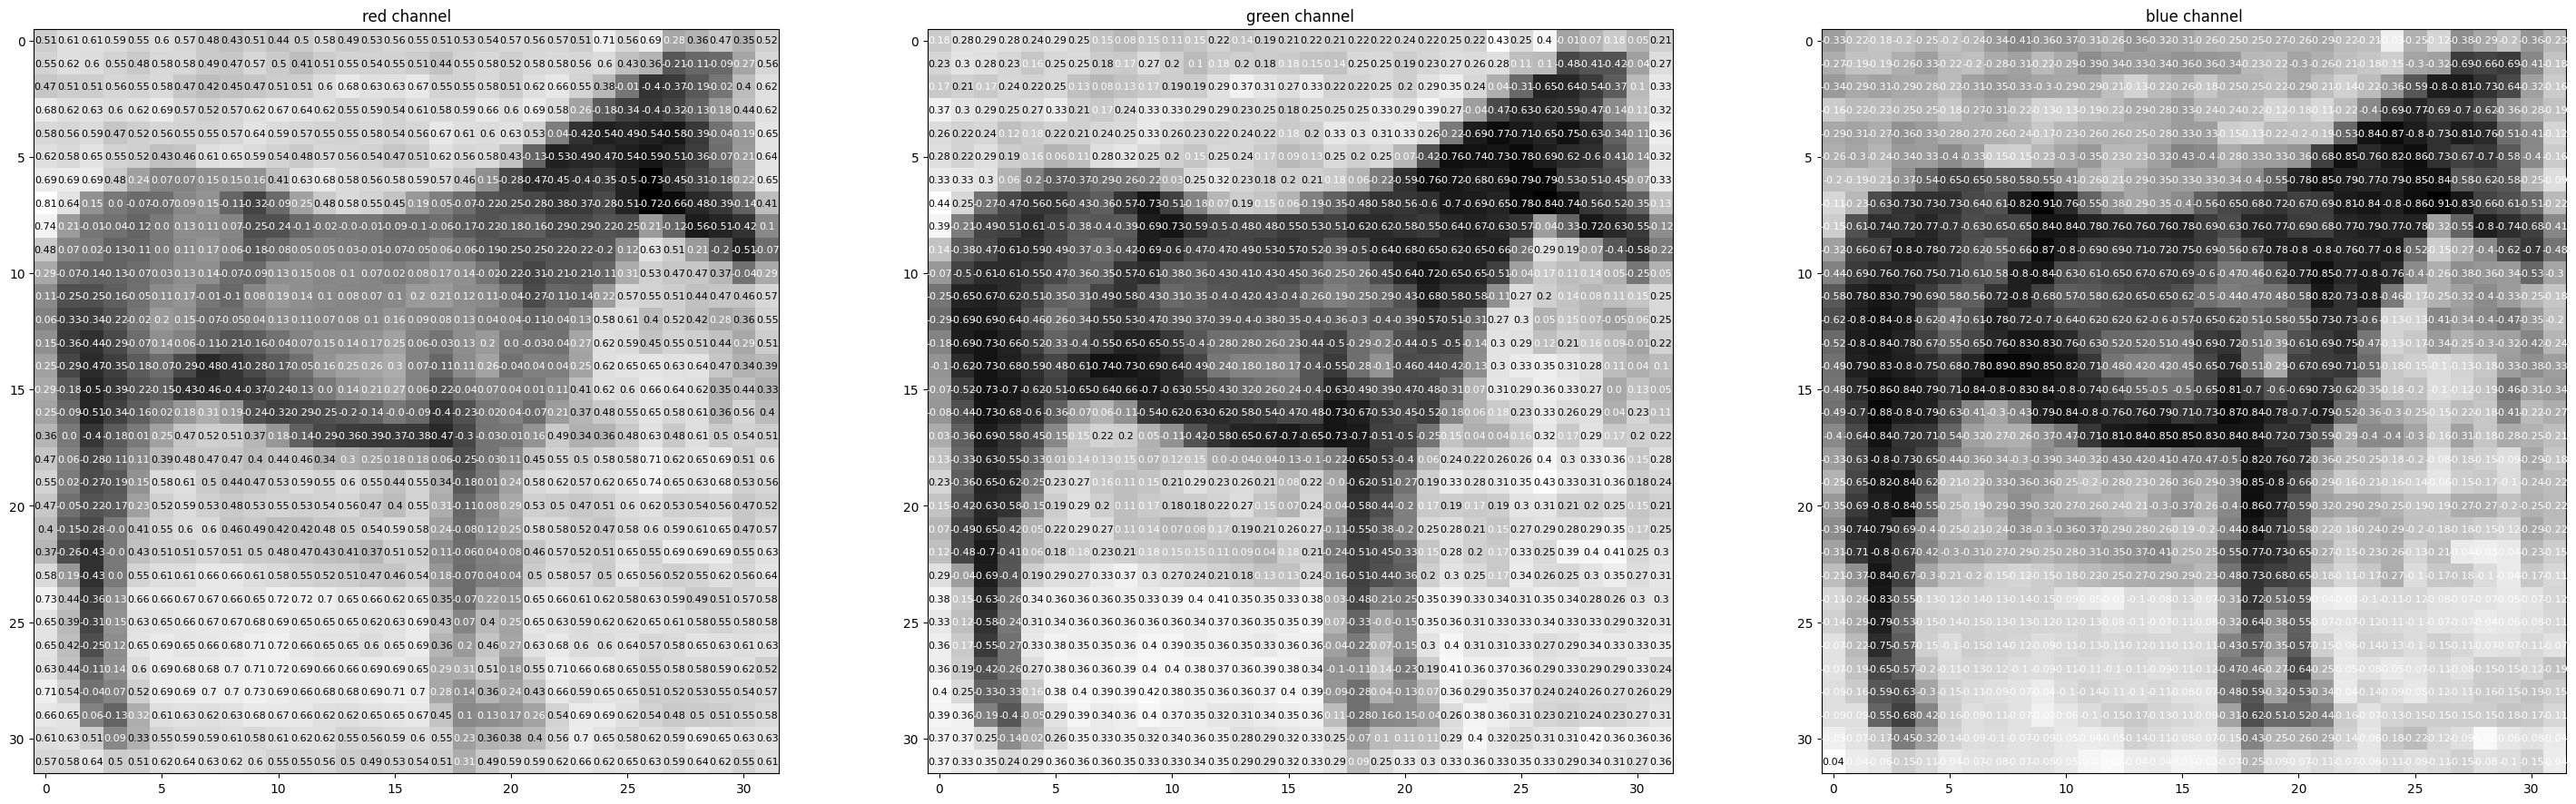

In [4]:
#The normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.
rgb_img = np.squeeze(images[19])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

# Defining the hyperparameters -

num_epochs = 30
learning_rate = 0.01
batch_size = 64

# Defining a Block class, representing a building block for the CustomModel -

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, k)

        # Convolutional layers for the block
        self.convs = nn.ModuleList()
        for _ in range(k):
            conv = nn.Conv2d(in_channels, out_channels,3, padding=1)
            # Initializing the weights of the convolutional layer -
            nn.init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.convs.append(conv)

        # Residual connection -
        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Initializing the weights of the residual connection -
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Performing the adaptive convolutions with the calculated weights -
        out = 0
        for i, conv in enumerate(self.convs):
            out += a[:, i:i + 1] * conv(x)

        # Adding the residual connection to the output
        res = self.residual(x)
        out += res
        return out

# CustomModel Class -

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Defining the backbone of the model -
        self.backbone = nn.Sequential(
            Block(3, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            Block(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce the spatial dimensions to 1x1
            nn.Flatten(),                 # Flatten the tensor into a 1D vector
            nn.Linear(64, 10)            # Fully connected layer to produce the final class scores
        )

    # Defining the forward pass of the model -
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

model = CustomModel()
print(model)

CustomModel(
  (backbone): Sequential(
    (0): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=3, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (residual): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=64, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (residual): Sequential()
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU

In [6]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

backbone = CustomModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) #RMS Prop Optimizer

# Define the learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

total_steps = len(trainloader)

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    accumulation_steps = 5

    optimizer.zero_grad()  # reset the gradients of the model parameters to zero before starting a new iteration of the training loop

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)  # Moving images and labels to the device
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Updating model parameters
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        total += labels.size(0)  # Update the total number of samples
        correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / len(dataloader)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disabling the gradient calculation (no_grad)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data  # Unpack the input data and labels
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss

            running_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / (i + 1)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

In [8]:
# Move the model to the device
model.to(device)

# Loop through each batch of data
for images, labels in trainloader:
    # Move the data to the device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass, backward pass, and update parameters
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

Epoch [1/30], Train Loss: 1.4066, Train Acc: 0.4954, Test Loss: 1.4035, Test Acc: 0.4829
Validation loss decreased (inf --> 1.403453).  Saving model ...
Epoch [2/30], Train Loss: 1.3066, Train Acc: 0.5333, Test Loss: 1.3562, Test Acc: 0.5053
Validation loss decreased (inf --> 1.356205).  Saving model ...
Epoch [3/30], Train Loss: 1.2541, Train Acc: 0.5541, Test Loss: 1.2230, Test Acc: 0.5642
Validation loss decreased (inf --> 1.223020).  Saving model ...
Epoch [4/30], Train Loss: 1.2144, Train Acc: 0.5660, Test Loss: 1.3091, Test Acc: 0.5405
Validation loss decreased (inf --> 1.309107).  Saving model ...
Epoch [5/30], Train Loss: 1.1951, Train Acc: 0.5757, Test Loss: 1.3404, Test Acc: 0.5142
Validation loss decreased (inf --> 1.340380).  Saving model ...
Epoch [6/30], Train Loss: 1.1652, Train Acc: 0.5863, Test Loss: 1.2058, Test Acc: 0.5688
Validation loss decreased (inf --> 1.205789).  Saving model ...
Epoch [7/30], Train Loss: 1.1430, Train Acc: 0.5950, Test Loss: 1.3901, Test Acc: 

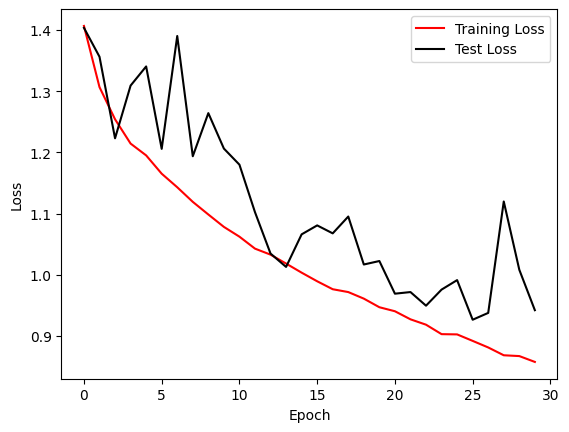

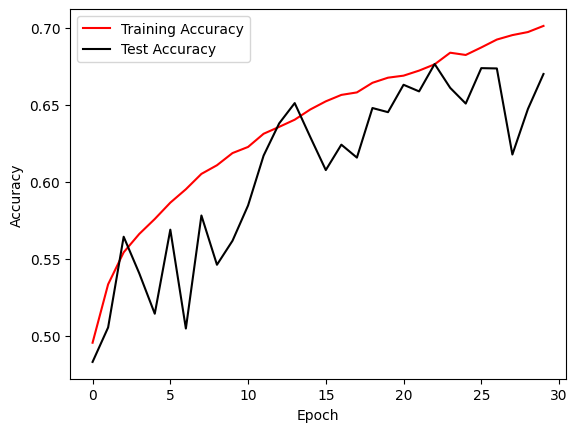

In [9]:
import time
import matplotlib.pyplot as plt

# Training parameters -
num_epochs = 30

test_loss_min = np.Inf # track change in validation loss

# Storing the loss and accuracy history -
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Loop through each epoch
for epoch in range(1,31):
    # Train the model for one epoch and calculate training loss and accuracy
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    # Validate the model and calculate validation loss and accuracy
    test_loss, test_acc = validate_epoch(model, testloader, criterion, device)

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    # Print the losses and accuracies for the current epoch
    print(f'Epoch [{epoch }/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


# save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = test_loss

end_time = time.time()

print(f'Training finished in {(end_time - start_time):.2f} seconds.')

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_history, label='Training Loss', color='red')
plt.plot(test_loss_history, label='Test Loss',color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_history, label='Training Accuracy',color='red')
plt.plot(test_acc_history, label='Test Accuracy',color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Defining the hyperparameters -
num_epochs = 40
learning_rate = 0.001
batch_size = 128


# Defining a Block class, representing a building block for the CustomModel -

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, k)

        # Convolutional layers for the block
        self.convs = nn.ModuleList()
        for _ in range(k):
            conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            # Initializing the weights of the convolutional layer -
            nn.init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.convs.append(conv)

        # Residual connection -
        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Initializing the weights of the residual connection -
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Performing the adaptive convolutions with the calculated weights -
        out = 0
        for i, conv in enumerate(self.convs):
            out += a[:, i:i + 1] * conv(x)

        # Adding the residual connection to the output
        res = self.residual(x)
        out += res
        return out

# CustomModel Class -

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Defining the backbone of the model -
        self.backbone = nn.Sequential(
            Block(3, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            Block(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Block(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            Block(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Block(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Block(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),


        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce the spatial dimensions to 1x1
            nn.Flatten(),                 # Flatten the tensor into a 1D vector
            nn.Linear(256, 10)            # Fully connected layer to produce the final class scores
        )

    # Defining the forward pass of the model -
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

model1 = CustomModel()
print(model)

CustomModel(
  (backbone): Sequential(
    (0): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=3, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (residual): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=64, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (residual): Sequential()
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

backbone = CustomModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model1.parameters(), lr=learning_rate) #RMS Prop Optimizer

# Define the learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

total_steps = len(trainloader)

In [12]:
def train_epoch(model1, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model1.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    accumulation_steps = 5

    optimizer.zero_grad()  # Reset gradients outside the loop

    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)  # Moving images and labels to the device
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Updating model parameters
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        total += labels.size(0)  # Update the total number of samples
        correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / len(dataloader)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

def validate_epoch(model1, dataloader, criterion, device):
    model1.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disabling the gradient calculation (no_grad)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data  # Unpack the input data and labels
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            outputs = model1(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss

            running_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    epoch_loss = running_loss / (i + 1)  # Calculate the average loss for the epoch
    epoch_acc = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

In [13]:
# Move the model to the device
model1.to(device)

# Loop through each batch of data
for images, labels in trainloader:
    # Move the data to the device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass, backward pass, and update parameters
    optimizer.zero_grad()
    outputs = model1(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

Epoch [1/40], Train Loss: 0.7926, Train Acc: 0.7193, Test Loss: 0.7327, Test Acc: 0.7438
Validation loss decreased (inf --> 0.732730).  Saving model1 ...
Epoch [2/40], Train Loss: 0.6188, Train Acc: 0.7809, Test Loss: 0.6485, Test Acc: 0.7756
Validation loss decreased (inf --> 0.648525).  Saving model1 ...
Epoch [3/40], Train Loss: 0.5242, Train Acc: 0.8178, Test Loss: 0.5779, Test Acc: 0.8065
Validation loss decreased (inf --> 0.577883).  Saving model1 ...
Epoch [4/40], Train Loss: 0.4487, Train Acc: 0.8438, Test Loss: 0.5429, Test Acc: 0.8106
Validation loss decreased (inf --> 0.542906).  Saving model1 ...
Epoch [5/40], Train Loss: 0.3882, Train Acc: 0.8666, Test Loss: 0.6234, Test Acc: 0.7904
Validation loss decreased (inf --> 0.623448).  Saving model1 ...
Epoch [6/40], Train Loss: 0.3360, Train Acc: 0.8845, Test Loss: 0.5735, Test Acc: 0.8089
Validation loss decreased (inf --> 0.573527).  Saving model1 ...
Epoch [7/40], Train Loss: 0.2865, Train Acc: 0.9007, Test Loss: 0.6286, Test

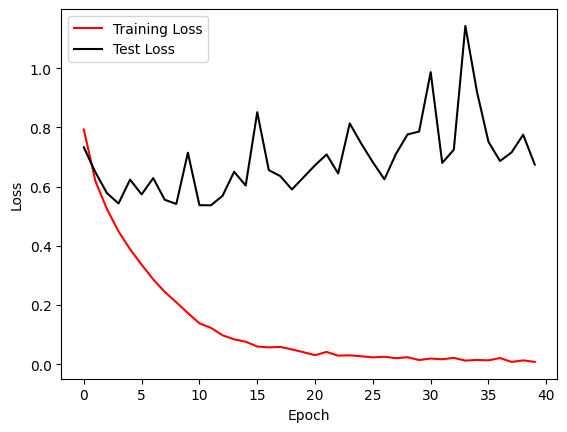

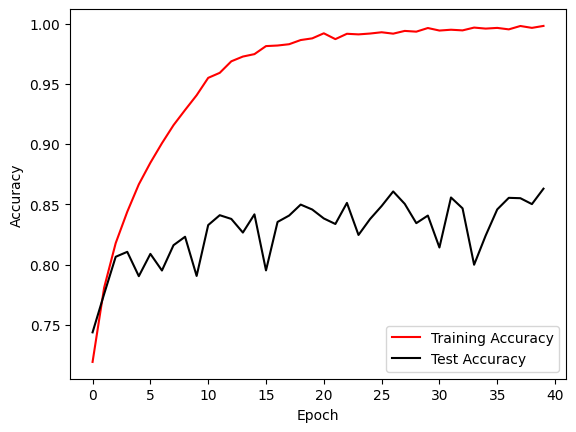

In [14]:
import time
import matplotlib.pyplot as plt

# Training parameters -
num_epochs = 40

test_loss_min = np.Inf # track change in validation loss

# Storing the loss and accuracy history -
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Loop through each epoch
for epoch in range(1,41):
    # Train the model1 for one epoch and calculate training loss and accuracy
    train_loss, train_acc = train_epoch(model1, trainloader, criterion, optimizer, device)
    # Validate the model1 and calculate validation loss and accuracy
    test_loss, test_acc = validate_epoch(model1, testloader, criterion, device)

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    # Print the losses and accuracies for the current epoch
    print(f'Epoch [{epoch }/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


# save model1 if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model1 ...'.format(
        test_loss_min,
        test_loss))
        torch.save(model1.state_dict(), 'model_cifar.pt')
        valid_loss_min = test_loss

end_time = time.time()

print(f'Training finished in {(end_time - start_time):.2f} seconds.')

# Plotting the loss curves
plt.figure()
plt.plot(train_loss_history, label='Training Loss', color='red')
plt.plot(test_loss_history, label='Test Loss',color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_history, label='Training Accuracy',color='red')
plt.plot(test_acc_history, label='Test Accuracy',color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()